In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Load Data

In [ ]:
import dask.dataframe as dd # use dask to load dataset which exceeds memory
data = dd.read_csv('./data.csv', dtype={'attributed_time': 'object'})

In [ ]:
# obtain counts of each class # require 3 mins to load -- show the imbalance
data_0, data_1 = data["is_attributed"].value_counts()

#plot
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']
counts= [data_0, data_1]
ax.set_ylabel('No. of clicks')
ax.set_xlabel("is_attributed")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

We observe that:
1. Dataset is huge, with more than 175 million observations
2. Dataset is highly imbalanced

Thus, following will be the steps for data pre-processing:

1. Random sampling, where the final dataset we will be using will be approximately 0.25 of the size of the current dataset
2. Check for duplicates and remove them (if any)
3. Do train-test split
4. Undersampling on training set to balance the class distribution
5. Deal with missing data (if any)

## Data Pre-processing

### Random Sampling (without replacement)

In [ ]:
# Read data by chunks of 10 million observations
# Sample 2.5 million observations randomly without replacement

data = pd.DataFrame()

chunksize = 10**7
with pd.read_csv('./data.csv', chunksize=chunksize) as reader:
  for chunk in reader:
    chunk = chunk.sample(n = int(chunksize/4), replace = False, random_state = 0)
    data = pd.concat([data, chunk])
    print(data.shape)

In [ ]:
print(data.shape)
print(data["is_attributed"].value_counts())

### Removing Duplicates

In [ ]:
# Check for duplicates
print('Check whether there are duplicates:', data.duplicated().any())
print('Number of duplicates:', sum(data.duplicated(subset=list(data.columns))))

In [ ]:
data = data.drop_duplicates()

print(data.shape)
print(data["is_attributed"].value_counts())

Since attributed_time is only available when is_attributed=1, this feature will not provide much useful information for analytics. Thus, we decided to drop the attributed_time column.

In [ ]:
# drop attributed time column
data = data.drop('attributed_time', axis=1)
data.head()

In [ ]:
data.to_csv('./data_sampled.csv', index=False)

### Train-test split

In [ ]:
data = pd.read_csv('./data_sampled.csv')

In [ ]:
X = data.iloc[:,:-1]
y = data["is_attributed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)
print(X_train.columns)

### Save sampled train and test datasets

In [ ]:
y_train = pd.DataFrame({'is_attributed': y_train})
y_test = pd.DataFrame({'is_attributed': y_test})

In [ ]:
train_sampled = pd.concat([X_train, y_train],  axis=1)
test_sampled = pd.concat([X_test, y_test],  axis=1)
#train_sampled.to_csv('./train_sampled.csv', index=False)
# test_sampled.to_csv('./test_sampled.csv', index=False)

In [ ]:
#Check; can comment out later
train_sampled.head(5)

### Undersampling

In [ ]:
def undersample(train):
  train_0 = train[train["is_attributed"] == 0]
  train_1 = train[train["is_attributed"] == 1]

  train_0_count, train_1_count = train["is_attributed"].value_counts()

  # Under-sample class 0
  train_0_under = train_0.sample(n = train_1_count, random_state = 0)

  # Merge undersampled class 0 and original class 1
  train_under = pd.concat([train_0_under, train_1], axis = 0)
  return train_under

In [ ]:
train_undersampled = undersample(train_sampled)

print(train_undersampled.shape)
print(train_undersampled["is_attributed"].value_counts())

In [ ]:
## Save undersampled data
train_undersampled.to_csv('./train_undersampled.csv', index=False)

## (Starting Point) Load Undersampled Train CSV Data

I have run and saved a copy of the unsampled data, I think can just start from here instead of running the undersampling process everytime

In [123]:
train = pd.read_csv('./train_undersampled.csv')
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,116992,15,1,34,245,2017-11-07 06:18:26,0
1,92610,3,1,13,280,2017-11-07 03:06:29,0
2,79894,2,1,19,122,2017-11-07 11:15:24,0
3,32746,3,1,31,480,2017-11-08 14:44:58,0
4,1638,2,1,20,236,2017-11-09 10:24:38,0


In [124]:
train["is_attributed"].value_counts()

0    93227
1    93227
Name: is_attributed, dtype: int64

In [125]:
# Redefine X_train and y_train
X_train, y_train = train.iloc[:,:-1], train["is_attributed"]

print(X_train.shape, y_train.shape)

(186454, 6) (186454,)


# EDA

### 1. Count of unique values of variables

In [126]:
unique_values = []

for x in train.iloc[:,:-1].columns:
  unique_values.append(len(train[x].unique()))

print(len(unique_values))
print(unique_values)

6
[84781, 243, 955, 148, 172, 124815]


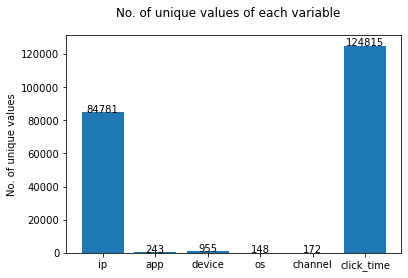

In [128]:
fig, ax = plt.subplots()
fig.suptitle('No. of unique values of each variable')
labels = train.iloc[:,:-1].columns.tolist()

ax.set_ylabel('No. of unique values')
ax.bar(labels, unique_values)

for index, value in enumerate(unique_values):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

### 1. Distribution of is_attributed



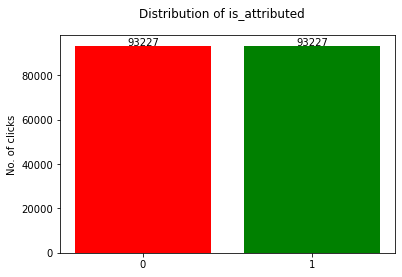

In [130]:
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, train['is_attributed'].value_counts(), color = ('red','green'))

for index, value in enumerate(train['is_attributed'].value_counts()):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

### 2. Time of Day for Clicks (in hour)

Extract day, hour, minute, second from click_time

In [132]:
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime
train['day'] = train_datetime.dt.day
train['hour'] = train_datetime.dt.hour
train['minute'] = train_datetime.dt.minute
train['second'] = train_datetime.dt.second

print(train.head())

       ip  app  device  os  channel          click_time  is_attributed  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0   
1   92610    3       1  13      280 2017-11-07 03:06:29              0   
2   79894    2       1  19      122 2017-11-07 11:15:24              0   
3   32746    3       1  31      480 2017-11-08 14:44:58              0   
4    1638    2       1  20      236 2017-11-09 10:24:38              0   

   click_date  day  hour  minute  second  
0  2017-11-07    7     6      18      26  
1  2017-11-07    7     3       6      29  
2  2017-11-07    7    11      15      24  
3  2017-11-07    8    14      44      58  
4  2017-11-07    9    10      24      38  


In [ ]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

train_min_0 = train[train["is_attributed"] == 0]['minute']
train_min_1 = train[train["is_attributed"] == 1]['minute']

In [ ]:
hours = 24 # 24 hours in a day

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_hour_0.hist(bins = hours - 1, color = "red")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_hour_1.hist(bins = hours - 1, color = "green")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

plt.tight_layout()
plt.show()

In [ ]:
minutes = 60 # 60 minutes in an hour

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_min_0.hist(bins = minutes - 1, color = "red")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_min_1.hist(bins = minutes - 1, color = "green")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

plt.tight_layout()
plt.show()

### 3. Average Number of Clicks

In [ ]:
train_0 = train[train["is_attributed"] == 0]
train_1 = train[train["is_attributed"] == 1]

num_ip_0 = train_0['ip'].nunique()
num_ip_1 = train_1['ip'].nunique()

num_app_0 = train_0['app'].nunique()
num_app_1 = train_1['app'].nunique()

num_clicks_0 = train_0.size
num_clicks_1 = train_1.size

avg_clicks_ip_0 = num_clicks_0 / num_ip_0
avg_clicks_ip_1 = num_clicks_1 / num_ip_1

avg_clicks_app_0 = num_clicks_0 / num_app_0
avg_clicks_app_1 = num_clicks_1 / num_app_1

print(num_ip_0, num_ip_1)
print(num_app_0, num_app_1)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per IP address')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_ip_0, avg_clicks_ip_1), color = ('red','green'))

Great difference between the two classes

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per app')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_app_0, avg_clicks_app_1), color = ('red','green'))

### 4. Distribution of Device


In [ ]:
fraud_data = train[train["is_attributed"] == 0]
notfraud_data = train[train["is_attributed"] == 1]

In [ ]:
device_labels = sorted(train["device"].unique().tolist())
device_fraud = []
device_notfraud = []

for device in device_labels:
  device_fraud.append(len(fraud_data[fraud_data["device"] == device]))
  device_notfraud.append(len(notfraud_data[notfraud_data["device"] == device]))

device_labels = [str(x) for x in device_labels]

In [ ]:
# Not fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale  
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()


# Fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for fradulent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale 
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()

In [ ]:
# For checks
print("Device Labels are: ", "\n", device_labels)
print("Non fradulent counts are: ", "\n", device_notfraud)
print("Fradulent counts are: ", "\n", device_fraud)

### 5. Distribution of Channel

In [ ]:
channel_labels = sorted(train["channel"].unique().tolist())
channel_fraud = []
channel_notfraud = []

for channel in channel_labels:
  channel_fraud.append(len(fraud_data[fraud_data["channel"] == channel]))
  channel_notfraud.append(len(notfraud_data[notfraud_data["channel"] == channel]))

channel_labels = [str(x) for x in channel_labels]

In [ ]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

In [ ]:
# For checks
print("Channel Labels are: ", "\n", channel_labels)
print("Non fradulent counts are: ", "\n", channel_notfraud)
print("Fradulent counts are: ", "\n", channel_fraud)

### 6. Distribution of IP

In [ ]:
ip_labels = sorted(train["ip"].unique().tolist())
ip_fraud = []
ip_notfraud = []

for ip in ip_labels:
  ip_fraud.append(len(fraud_data[fraud_data["ip"] == ip]))
  ip_notfraud.append(len(notfraud_data[notfraud_data["ip"] == ip]))

ip_labels = [str(x) for x in ip_labels]

In [ ]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for non-fraudlent cases", fontsize = 16) 
plt.xlabel("IP Adress", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

In [ ]:
# For checks
print("IP Labels are: ", "\n", ip_labels)
print("Non fradulent counts are: ", "\n", ip_fraud)
print("Fradulent counts are: ", "\n", ip_notfraud)

### 7. Distribution of OS

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.countplot(x="os", hue="is_attributed", data=train)
ax.set_yscale("log")
ax.legend(loc="upper right")
# generate graph xlabels
attributed_os = train[train["is_attributed"]==1]["os"].unique()
os_xlabels = [str(i) if i in attributed_os else "" for i in sorted(train["os"].unique())]
ax.set_xticklabels(os_xlabels, fontsize=8)
ax.set_title("Distribution of OS")
plt.show()

In [ ]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'conversion_rate']
merge

In [ ]:
fig,ax = plt.subplots(figsize=(16, 8))

l1 = ax.plot(merge.click_count, color="red", label="Count of Clicks")
#ax.set_yscale("log")
ax.set_ylabel("Count of Clicks")

ax2=ax.twinx()
l2 = ax2.plot(merge.conversion_rate, color="blue", label="Conversion Rate")
ax2.set_ylabel("Conversion Rate")

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
ax.set_xlabel("index")
ax.set_title("Conversion Rate over Count of OS")
plt.show()

### 8. Average Time between Clicks

In [ ]:
from datetime import datetime

sorted_ip = sorted(train["ip"].unique())
sorted_ip_attributed = sorted(train[train["is_attributed"]==1]["ip"].unique())
click_average_time_0 = []
click_average_time_1 = []

def get_average_time(click_time):
  count = len(click_time)
  # assign -1 if click once
  if count <= 1:
    return -1
  else:
    start_time = datetime.strptime(click_time[0], '%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(click_time[count-1], '%Y-%m-%d %H:%M:%S')
    difference = (end_time - start_time).total_seconds()/60
    if difference == 0:
      return 0
    else:
      return difference/(count-1)

for ip in sorted_ip:
  click_time = sorted(train[train["ip"]==ip]["click_time"].values)
  average_time = get_average_time(click_time)
  # remove -1 values for better visualization
  if average_time != -1:
    if ip in sorted_ip_attributed:
      click_average_time_1.append(average_time)
    else:
      click_average_time_0.append(average_time)


In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.histplot([click_average_time_0, click_average_time_1], multiple = "stack")
ax.set_xlabel("Time (in minutes)")
ax.set_title("Average Time between Clicks")
plt.show()

In [ ]:
rng = range(int(min(click_average_time_0)), int(max(click_average_time_0)) + 60, 60)

fig, axes = plt.subplots(2, 1, figsize=(20, 15))
# Histogram for fraud clicks
sns.histplot(click_average_time_0, ax = axes[0], bins = rng, color = "red")
axes[0].set_xlabel("Time (in minutes)")
axes[0].set_title("Average Time between Fraud Clicks")

# Histogram for normal clicks
sns.histplot(click_average_time_1, ax = axes[1], bins = rng, color = "green")
axes[1].set_xlabel("Time (in minutes)")
axes[1].set_title("Average Time between Normal Clicks")

plt.show()

### 9. Correlation Heatmap

In [ ]:
#Cannot be done, all variables categorical mostly categorical, correlation for numerical variables only (this case none is numerical --> only categorical, datetime)
#Tried doing chi-square, but due to the large number of categories in each features (ip, app,device), the memory is limited and unable to do so

### 10. Conversion Rate between clicky IP and non clicky IP

In [ ]:
#work with categorical varibles
categorical = train[["ip", "app", "device", "os", "channel", "is_attributed"]].apply(lambda x: x.astype("category"))
categorical.is_attributed = categorical.is_attributed.astype(int)

In [ ]:
#Get the number of clicks and downloads per ip and app
agg_func_count = {'is_attributed': ['count', 'sum']} 
x = categorical.groupby(["ip","app"]).agg(agg_func_count)
x.columns = ["clicks", "downloads"]
x.head(5)

In [ ]:
#removed ip + apps with 0 clicks
x = x[x.clicks != 0 ]

#visualisation by number clicks and downloads --> shows that those ip that downloaded the app tend to have lesser clicks on app (majority number of clicks less than 20)
#whether the ip downloaded the app seems rather random with no clear patterns
fig,ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=x, x="clicks", y="downloads", alpha=0.5,ax=ax,s=75)
ax.set_title("clicks vs downloads")
plt.show()

In [ ]:
# adding conversion rate
x["conversion_rate"] = x.downloads/x.clicks


# visualisation by conversion rates vs clicks --> shows that conversion rate varies (app tend to download once, so depends on number of clicks)
# but majority that downloaded tend to have high conversion rate (shown by the darker colours that indicate overlapping)
fig,ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=x, x="clicks", y="conversion_rate", hue="downloads", alpha=0.3, ax=ax,s=75)
ax.set_title("clicks vs conversion rate by ip and app")
plt.show()

In [ ]:
#each ip can have multiple clicks
train["ip"].value_counts()

In [ ]:
#conversion rate just by looking at ip
#can have multiple downloads per ip

x = categorical.groupby(["ip"]).agg(agg_func_count)
x.columns = ["clicks", "downloads"]
x = x.sort_values('clicks', ascending=False).reset_index()
x["conversion_rate"] = x.downloads/x.clicks
x.head()

In [ ]:
#comparing clicks and conversion rate for top 500 ip addresses
#whether there is download seem pretty random, does not really seem to be related to clicks
fig,ax = plt.subplots(figsize=(12,6))

l1 = ax.plot(x.clicks[:500], color="red", marker="o", label="count")
ax.set_ylabel("clicks")

ax2=ax.twinx()
l2 = ax2.plot(x.conversion_rate[:500], color="blue", marker="o", label="conversion")
ax2.set_ylabel("conversion rate")

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
ax.set_xlabel("index")
ax.set_title("Top 500 ip with most clicks")
plt.show()

In [ ]:
#similar to previous plot visualise --> as number of clicks increases, the conversion rate decreases (make sense cause people tend to download once only thus decreases due to formula)
# but majority that downloaded tend to have high conversion rate (shown by the darker colours that indicate overlapping)
fig,ax = plt.subplots(figsize=(12,6))
sns.scatterplot(data=x, x="clicks", y="conversion_rate", hue="downloads", alpha=0.3, ax=ax,s=75)
ax.set_title("clicks vs conversion rate by ip")
plt.show()

### 11. Channel and Conversion Rate

In [133]:
train['click_date'] = train_datetime.dt.date
train['dateTime'] = pd.to_datetime(train.click_date) + pd.to_timedelta(train.hour, unit='h')
train_isAttributed = train[train['is_attributed'] == 1]

In [134]:
number_click_channel = pd.DataFrame(train.groupby(by=["channel"]).size()).reset_index()
number_click_channel = number_click_channel.rename({0: 'count'}, axis=1)
number_click_channel.rename(columns={'count':'number_click'}, inplace=True)

number_download_channel = pd.DataFrame(train_isAttributed.groupby(by=["channel"]).size()).reset_index()
number_download_channel = number_download_channel.rename({0: 'count'}, axis=1)
number_download_channel.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_channel = number_click_channel.join(number_download_channel.set_index('channel'), on="channel")
conversion_rate_channel['number_download'] = conversion_rate_channel['number_download'].fillna(0)
conversion_rate_channel['conversion_rate'] = conversion_rate_channel['number_download']/conversion_rate_channel['number_click']

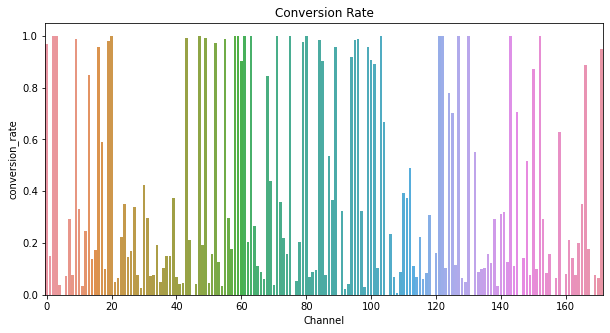

In [135]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=conversion_rate_channel, x='channel', y='conversion_rate')
ax.set_xlabel("Channel")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 12. Device and Conversion Rate

In [136]:
number_click_device = pd.DataFrame(train.groupby(by=["device"]).size()).reset_index()
number_click_device = number_click_device.rename({0: 'count'}, axis=1)
number_click_device.rename(columns={'count':'number_click'}, inplace=True)

number_download_device = pd.DataFrame(train_isAttributed.groupby(by=["device"]).size()).reset_index()
number_download_device = number_download_device.rename({0: 'count'}, axis=1)
number_download_device.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_device = number_click_device.join(number_download_device.set_index('device'), on="device")
conversion_rate_device['number_download'] = conversion_rate_device['number_download'].fillna(0)
conversion_rate_device['conversion_rate'] = conversion_rate_device['number_download']/conversion_rate_device['number_click']

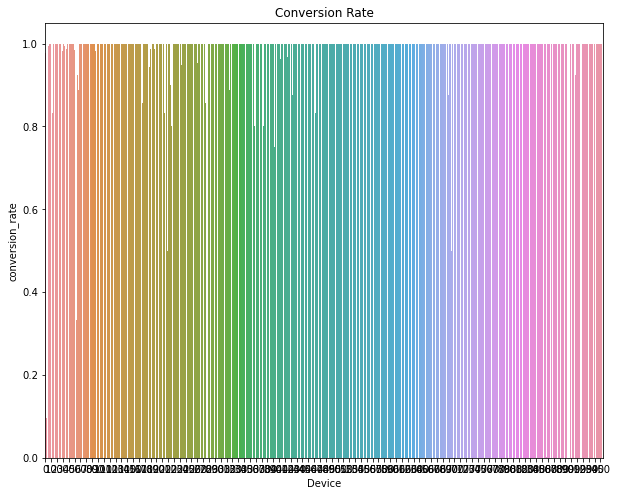

In [137]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=conversion_rate_device, x='device', y='conversion_rate')
ax.set_xlabel("Device")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 13. Click and Conversion Rate throughout the day

In [138]:
number_click_time = pd.DataFrame(train.groupby(by=["dateTime"]).size()).reset_index()
number_click_time = number_click_time.rename({0: 'count'}, axis=1)
number_click_time.rename(columns={'count':'number_click'}, inplace=True)

number_download_time= pd.DataFrame(train_isAttributed.groupby(by=["dateTime"]).size()).reset_index()
number_download_time = number_download_time.rename({0: 'count'}, axis=1)
number_download_time.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_time = number_click_time.join(number_download_time.set_index('dateTime'), on="dateTime")
conversion_rate_time['number_download'] = conversion_rate_time['number_download'].fillna(0)
conversion_rate_time['conversion_rate'] = conversion_rate_time['number_download']/conversion_rate_time['number_click']
conversion_rate_time = conversion_rate_time.set_index('dateTime')

C:\Users\vanes\AppData\Local\Temp/ipykernel_3280/2274248138.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(conversion_rate_time.index, rotation=-80)


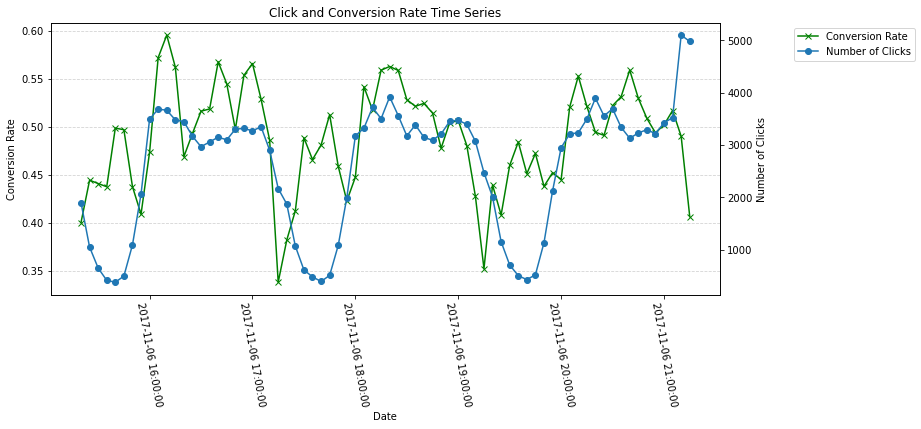

In [139]:
# setting figure size to 12, 10
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
# Labelling the axes and setting
# a title
ax.set_xlabel("Date")
ax.set_ylabel("Conversion Rate")
ax2.set_ylabel("Number of Clicks")
ax.set_title("Click and Conversion Rate Time Series")

# plotting the "A" column alone
p1, = ax.plot(conversion_rate_time['conversion_rate'],  color='green', marker='x', label='Conversion Rate')
p2, = ax2.plot(conversion_rate_time['number_click'], marker='o', label="Number of Clicks")
ax.set_xticklabels(conversion_rate_time.index, rotation=-80)
plt.legend(handles=[p1,p2],bbox_to_anchor=(1.2, 1), loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
ax2.yaxis.grid(False)
plt.show()

#  Feature Engineering

### Add channel, device, and dateTime conversion rate to train data

In [140]:
train = pd.merge(train,conversion_rate_channel[['channel','conversion_rate']],on='channel')
train.rename({'conversion_rate': 'channel_conversion_rate'}, axis=1, inplace=True)

In [141]:
train = pd.merge(train,conversion_rate_device[['device','conversion_rate']],on='device')
train.rename({'conversion_rate': 'device_conversion_rate'}, axis=1, inplace=True)

In [142]:
conversion_rate_time = conversion_rate_time.reset_index(level=0)
train = pd.merge(train,conversion_rate_time[['dateTime','conversion_rate']],on='dateTime')
train.rename({'conversion_rate': 'dateTime_conversion_rate'}, axis=1, inplace=True)

### Different combination/aggregation of features

In [143]:
#functions to help aggregate and count

#total counts
def agg_counts(df, group_cols, name):
  grp = df.groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#unique counts
def agg_unique(df, group_cols, unique_col, name):
  grp = df.groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#cumulative counts
def agg_cum_count(df, group_cols, name):
  grp = df.groupby(group_cols).cumcount()
  df[name] = grp.values
  return df

#variance
def agg_var(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].var().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

#mean
def agg_mean(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].mean().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

In [144]:
#data to do combi on 

#include date time
import datetime
# train_agg = train.copy()
# train_agg["click_time"] = pd.to_datetime(train["click_time"])
# train_agg["hour"] = train_agg["click_time"].dt.hour
train["dayOfWeek"] = train["click_time"].dt.weekday
train.head()

,ip,app,device,os,channel,click_time,is_attributed,click_date,day,hour,minute,second,dateTime,channel_conversion_rate,device_conversion_rate,dateTime_conversion_rate,dayOfWeek
0,116992,15,1,34,245,2017-11-07 06:18:26,0,2017-11-07,7,6,18,26,2017-11-07 06:00:00,0.0368,0.414982,0.516346,1
1,136145,12,1,22,245,2017-11-07 06:10:42,0,2017-11-07,7,6,10,42,2017-11-07 06:00:00,0.0368,0.414982,0.516346,1
2,32371,15,1,11,245,2017-11-07 06:51:41,0,2017-11-07,7,6,51,41,2017-11-07 06:00:00,0.0368,0.414982,0.516346,1
3,105571,15,1,11,245,2017-11-07 06:34:39,0,2017-11-07,7,6,34,39,2017-11-07 06:00:00,0.0368,0.414982,0.516346,1
4,136883,15,1,23,245,2017-11-07 06:33:56,0,2017-11-07,7,6,33,56,2017-11-07 06:00:00,0.0368,0.414982,0.516346,1


In [145]:
#try some combinations, to see if there is a relationship
#total counts
train= agg_counts(train, ["ip", "app", "device", "os", "channel"], 'ip_app_dev_os_cha_counts')
train = agg_counts(train, ["ip", "app", "device", "os"], 'ip_app_dev_os_counts')
train = agg_counts(train, ["ip", "app", "device"], 'ip_app_dev_counts')
train= agg_counts(train, ["ip", "app", "os"], 'ip_app_os_counts')
train = agg_counts(train, ["ip", "app", "hour"], 'ip_app_hour_counts')
train = agg_counts(train, ["ip", "channel"], 'ip_channel_counts')
train = agg_counts(train, ["ip", "app"], 'ip_app_counts')
train = agg_counts(train, ["ip", "day"], 'ip_per_day')
train = agg_counts(train, ["ip"], "ip_counts")

In [146]:
#unique counts
train = agg_unique(train, ["ip"], "app", "uniq_app_per_ip")
train = agg_unique(train, ["ip"], "device", "uniq_device_per_ip")
train = agg_unique(train, ["ip"], "channel", "uniq_channel_per_ip")
train = agg_unique(train, ["ip"], "os", "uniq_os_per_ip")
train= agg_unique(train, ["ip", "device", "os"], "app", "uniq_app_per_ip_dev_os")
train = agg_unique(train, ["app"], "channel", "uniq_channel_per_app")
train = agg_unique(train, ["ip", "day"], "hour", "uniq_hour_per_ip_day")
train = agg_unique(train, ["ip", "app"], "os", "uniq_os_per_ip_app")

In [147]:
#cumulative counts
train = agg_cum_count(train, ["ip"], "cum_count_by_ip")
train = agg_cum_count(train, ["ip", "device"], "cum_count_by_ip_device")
train = agg_cum_count(train, ["ip", "device","os"], "cum_count_by_ip_device_os")
train = agg_cum_count(train, ["ip", "device","os","channel"], "cum_count_by_ip_device_os_channel")
train = agg_cum_count(train, ["ip", "device","os","channel","app"], "cum_count_by_ip_device_os_channel_app")
train = agg_cum_count(train, ["app"], "cum_count_by_app")
train = agg_cum_count(train, ["ip", "app"], "cum_count_by_ip_app")

In [148]:
#variance
train = agg_var(train, ["ip","app","channel"], "hour", "var_hour_by_ip_app_channel")
train = agg_var(train, ["ip","app","os"], "hour", "var_hour_by_ip_app_os")
train = agg_var(train, ["ip","app","device"], "hour", "var_hour_by_ip_app_device")
train = agg_var(train, ["ip","app","channel"], "day", "var_day_by_ip_app_channel")
train = agg_var(train, ["ip","app","os"], "day", "var_day_by_ip_app_os")
train  = agg_var(train, ["ip","app","device"], "day", "var_day_by_ip_app_device")

In [149]:
#mean
train = agg_mean(train, ["ip","app","channel"], "hour", "mean_hour_by_ip_app_channel")
train = agg_mean(train, ["ip","app","os"], "hour", "mean_hour_by_ip_app_os")
train = agg_mean(train, ["ip","app","device"], "hour", "mean_hour_by_ip_app_device")

In [150]:
#density plots get array of labels
xlab = np.array(train_agg.columns[10:len(train_agg.columns)])

def plot_rbyc(data_plot, xlab_arr, r, c, log = False):
  
  data = data_plot.copy()

  if log == True:
    data[xlab_arr] = np.log10(data_plot[xlab_arr])
    
  fig, axs = plt.subplots(r,c, figsize=(5*c, 2*r))
  row, col = 0, 0
    
  for i in range(0, len(xlab_arr)):
    sns.kdeplot(data=data, x=xlab_arr[i], hue="is_attributed", ax=axs[row,col], fill=True)
    if col == c-1:
      col = 0
      row += 1
    else:
      col +=1

  to_be_empty = r*c - len(xlab_arr)
  while to_be_empty > 0:
      axs[row,col].set_visible(False)
      if col == c-1:
        col = 0
        row += 1
      else:
        col +=1
      to_be_empty -= 1
      
  plt.tight_layout()
  plt.show()


Different combinations of aggregating original features: 



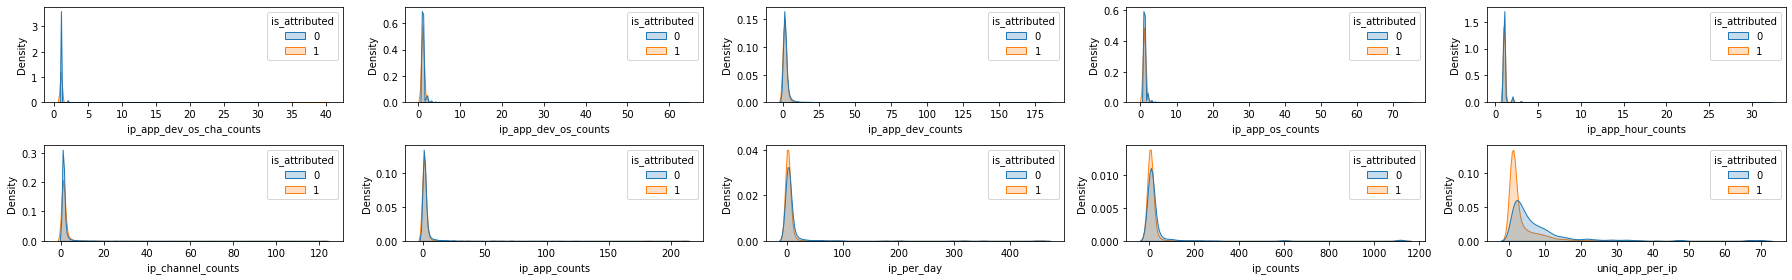

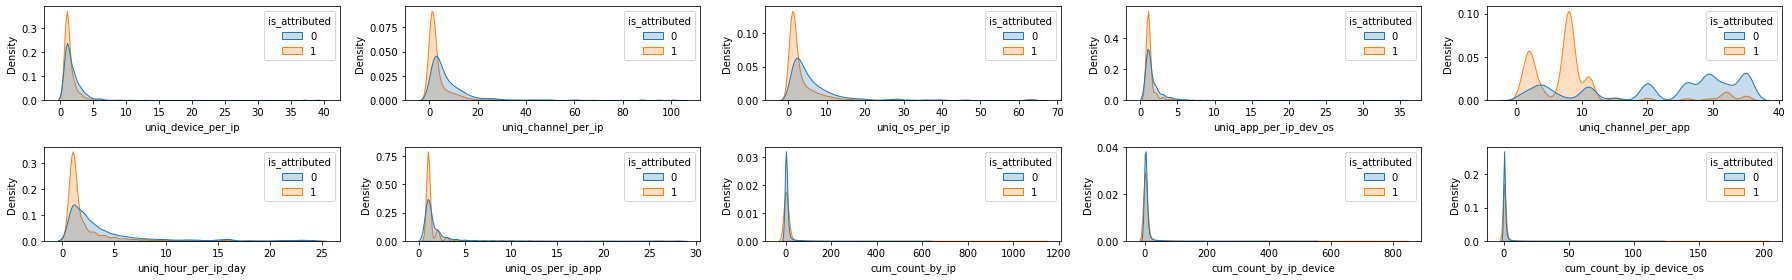

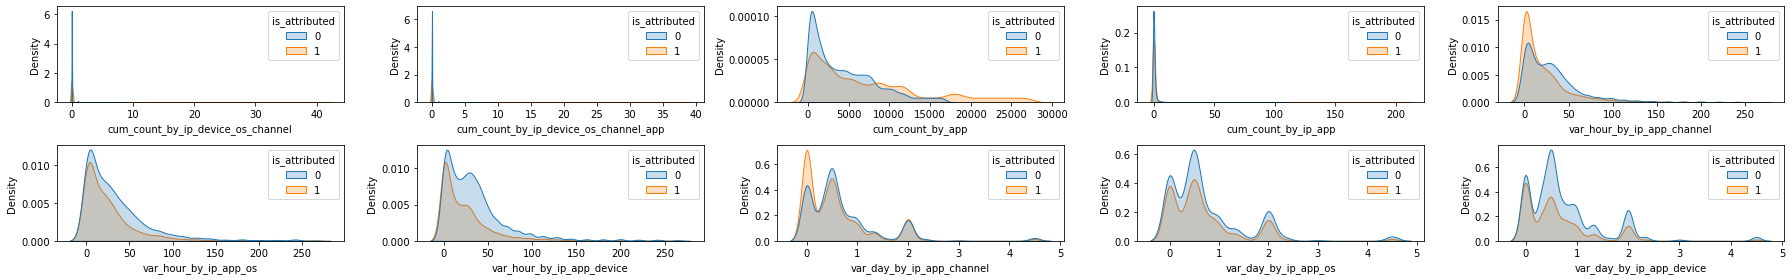

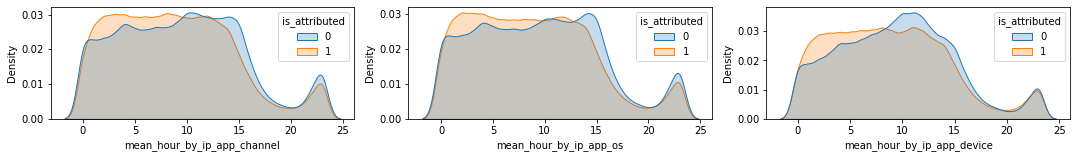

In [151]:
#plot all density plots -- 2 mins
r, c = 2, 5
total = r*c
print("Different combinations of aggregating original features: \n")
for i in range(0, len(xlab), total):
  x = xlab[i:i+total]
  plot_rbyc(train_agg, x, r, c)

## Time till next click

In [152]:
GROUP_BY_NEXT_CLICKS = [
    
    # ip with one other feature
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'device']},
    {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'channel']},
    
    
    # ip with two other features
    {'groupby': ['ip', 'app', 'device']},
    {'groupby': ['ip', 'app', 'os']},
    {'groupby': ['ip', 'app', 'channel']},
    {'groupby': ['ip', 'device', 'os']},
    {'groupby': ['ip', 'device', 'channel']},
    {'groupby': ['ip', 'os', 'channel']},

    # ip with three other features
    {'groupby': ['ip', 'app', 'device', 'os']},
    {'groupby': ['ip', 'app', 'device', 'channel']},
    {'groupby': ['ip', 'device', 'os', 'channel']},

    # ip with all other features
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    
    train[new_feature] = train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'device'], and saving time to next click in: ip_device_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'app', 'device'], and saving time to next click in: ip_app_device_nextClick
>> Grouping by ['ip', 'app', 'os'], and saving time to next click in: ip_app_os_nextClick
>> Grouping by ['ip', 'app', 'channel'], and saving time to next click in: ip_app_channel_nextClick
>> Grouping by ['ip', 'device', 'os'], and saving time to next click in: ip_device_os_nextClick
>> Grouping by ['ip', 'device', 'channel'], and saving time to next click in: ip_device_channel_nextClick
>> Grouping by ['ip', 'os', 'channel'], and saving time to next click in: ip_os_channel_nextClick
>> Gro

,ip,app,device,os,channel,click_time,is_attributed,click_date,day,hour,...,ip_app_device_nextClick,ip_app_os_nextClick,ip_app_channel_nextClick,ip_device_os_nextClick,ip_device_channel_nextClick,ip_os_channel_nextClick,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick
0,116992,15,1,34,245,2017-11-07 06:18:26,0,2017-11-07,7,6,...,31022.0,NaN,59605.0,NaN,59605.0,NaN,NaN,59605.0,NaN,NaN
1,136145,12,1,22,245,2017-11-07 06:10:42,0,2017-11-07,7,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32371,15,1,11,245,2017-11-07 06:51:41,0,2017-11-07,7,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,105571,15,1,11,245,2017-11-07 06:34:39,0,2017-11-07,7,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,136883,15,1,23,245,2017-11-07 06:33:56,0,2017-11-07,7,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# plt.figure(figsize=(20, 30))
# for index, var in enumerate(train.columns[11:26]):
#   plt.subplot(5, 3, index+1)
#   var_0 = train[train['is_attributed']==0][var]
#   var_1 = train[train['is_attributed']==1][var]
#   plt.hist([var_0, var_1], label=["0", "1"])
#   plt.legend(loc="best")
#   plt.ylabel('Count')
#   plt.xlabel('Time (in seconds)')
#   plt.title(f"Distribution of {var}")

# plt.show()

In [ ]:
## for normal entries, they peak when the time btw clicks is ard 0s
## on the other hand for fraud entries, they when the time btw clicks is ard 0s and 80000s (ard 1 day)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BT4012/dataset/train_FE5.csv')

NameError: name 'data' is not defined

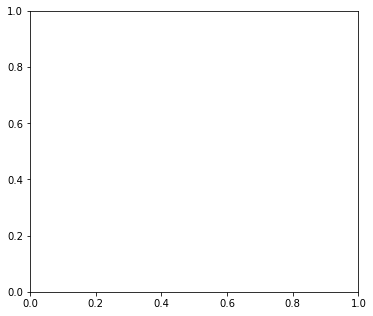

In [154]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[11:26]):
  plt.subplot(5, 3, index+1)
  sns.kdeplot(data=data, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

##  Clicks on app ad before & after

In [ ]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    train['prev_'+fname] = train.groupby(fset).cumcount().rename('prev_'+fname)
        
    # Clicks in the future
    train['future_'+fname] = train.iloc[::-1].groupby(fset).cumcount().rename('future_'+fname).iloc[::-1]
 
train.head()

In [ ]:
# plt.figure(figsize=(20, 15))
# for index, var in enumerate(train.columns[26:30]):
#   plt.subplot(2, 2, index+1)
#   var_0 = train[train['is_attributed']==0][var]
#   var_1 = train[train['is_attributed']==1][var]
#   plt.hist([var_0, var_1], label=["0", "1"])
#   plt.legend(loc="best")
#   plt.yscale("log")
#   plt.ylabel('Count')
#   plt.xlabel('Number of Clicks')
#   plt.title(f"Distribution of {var}")

# plt.show()

In [ ]:
plt.figure(figsize=(20, 15))
for index, var in enumerate(data.columns[26:30]):
  plt.subplot(2, 2, index+1)
  sns.kdeplot(data=data, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

## Confidence Rates for is_attributed

In [ ]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(10**6) # 1000 views -> 50% confidence, 100 views -> 33% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}.".format(cols, new_feature))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    train = train.merge(
        group_object['is_attributed'].apply(rate_calculation).reset_index().
        rename(index=str,columns={'is_attributed': new_feature})[cols + [new_feature]],
        on=cols, how='left'
    )
    
train.head()

In [ ]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[30:]):
  plt.subplot(6, 2, index+1)
  plt.scatter(x="ip", y=var, data=train[train['is_attributed']==1], color="orange", alpha=0.1)
  plt.scatter(x="ip", y=var, data=train[train['is_attributed']==0], color="blue", alpha=0.1)
  plt.legend(["1", "0"], loc="best")
  plt.ylabel('Confidence Rate')
  plt.xlabel('IP')
  plt.title(f"Distribution of {var}")

plt.show()

In [ ]:
##save the generated features
train.to_csv('/content/drive/MyDrive/BT4012/dataset/train_FE5.csv', index=False)

## Combining device & IP

In [ ]:
train['device_ip'] = train['device'].map(str) + train['ip'].map(str)
train.head()

In [ ]:
device_ip_1 = train[train['is_attributed'] == 1]['device_ip']
device_ip_0 = train[train['is_attributed'] == 0]['device_ip']

set_device_ip_1 = set(device_ip_1.unique())
set_device_ip_0 = set(device_ip_0.unique())

print('No. of unique device_ip that downloaded app:', len(set_device_ip_1))
print('No. of unique device_ip that did not download app:', len(set_device_ip_0))

In [ ]:
# device_ip that always download app after clicking
device_ip_download = set_device_ip_1.difference(set_device_ip_0)

# device_ip that always do not download app after clicking
device_ip_fraud = set_device_ip_0.difference(set_device_ip_1)

print('No. of device_ip that ALWAYS downloaded app:', len(device_ip_download))
print('No. of device_ip that NEVER downloaded app:', len(device_ip_fraud))

In [ ]:
pct_device_ip_download = (len(device_ip_download) / len(set_device_ip_1))*100
pct_device_ip_fraud = (len(device_ip_fraud) / len(set_device_ip_0))*100

print('Percentage of device_ip that ALWAYS downloaded app:', round(pct_device_ip_download, 2), '%')
print('Percentage of device_ip that NEVER downloaded app:', round(pct_device_ip_fraud, 2), '%')

## Combining device & hour

In [ ]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

In [ ]:
train['device_hour'] = train['device'].map(str) + train['hour'].map(str)
train.head()

In [ ]:
device_hour_1 = train[train['is_attributed'] == 1]['device_hour']
device_hour_0 = train[train['is_attributed'] == 0]['device_hour']

set_device_hour_1 = set(device_hour_1.unique())
set_device_hour_0 = set(device_hour_0.unique())

print('No. of unique device_hour that downloaded app:', len(set_device_hour_1))
print('No. of unique device_hour that did not download app:', len(set_device_hour_0))

In [ ]:
# device_hour that always download app after clicking
device_hour_download = set_device_hour_1.difference(set_device_hour_0)

# device_hour that always do not download app after clicking
device_hour_fraud = set_device_hour_0.difference(set_device_hour_1)

print('No. of device_hour that ALWAYS downloaded app:', len(device_hour_download))
print('No. of device_hour that NEVER downloaded app:', len(device_hour_fraud))

In [ ]:
pct_device_hour_download = (len(device_hour_download) / len(set_device_hour_1))*100
pct_device_hour_fraud = (len(device_hour_fraud) / len(set_device_hour_0))*100

print('Percentage of device_hour that ALWAYS downloaded app:', round(pct_device_hour_download, 2), '%')
print('Percentage of device_hour that NEVER downloaded app:', round(pct_device_hour_fraud, 2), '%')

# Feature Selection

In [ ]:
#See all the attributes that we have
train.info()

<p>Drop attribute_time, click_time, dateTime, and click_date column</p>

In [ ]:
train = train.drop(['click_date', 'dateTime','attributed_time','click_time'], axis=1)

In [ ]:
y_train = train['is_attributed']
x_train = train.drop('is_attributed', axis=1)

<p>Convert device_ip and device_hour to numeric type as data must be int, float or bool for lightGBM</p>

In [ ]:
x_train['device_ip'] =  pd.to_numeric(x_train['device_ip'])
x_train['device_hour'] =  pd.to_numeric(x_train['device_hour'])

In [ ]:
# Feature importance
import lightgbm as lgb
from sklearn.feature_selection import RFE
#lightGBM model fit
gbm = lgb.LGBMRegressor()
gbm.fit(x_train, y_train)
gbm.booster_.feature_importance()

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':x_train.columns, 'fea_imp':gbm.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)

In [ ]:
lightGBM_top20_features = fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False).head(20)

## Response Coding for Categorical Variables

In [ ]:
from tqdm import tqdm

# what is alpha
def get_feature_dict(alpha, feature, df):
  value_count = train[feature].value_counts()
  feature_dict = dict()
  value_count_items = value_count.items()

  class_0 = train['is_attributed'] == 0
  class_1 = train['is_attributed'] == 1

  for i, denominator in tqdm(value_count_items):
    b = train[feature] == i
    vec = []

    for k in range(2):
      if k == 0:
        cls_cnt = train.loc[class_0 & b]
      else:
        cls_cnt = train.loc[class_1 & b]
      
      vec.append((cls_cnt.shape[0] + 10*alpha)/ (denominator + 20*alpha))
    
    feature_dict[i] = vec
  
  return feature_dict



def get_feature(alpha, feature, df, feature_dict):
  value_count = train[feature].value_counts()
  value_count_keys = dict(value_count).keys()
  
  feature = []
  for index, row in tqdm(df.iterrows()):
    if row[feature] in value_count_keys:
      feature.append(feature_dict[row[feature]])
    
    else:
      feature.append([1/2, 1/2])
  
  return feature